# Cell 2 cell game assignment

---

# 

# Imports

#### Standard library imports

In [1]:
import sys
sys.path.append("../")

import os

#### Third party imports

In [156]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
import plotly.express as px
import matplotlib.pyplot as plt
# from sklearn import metrics
import plotly.graph_objects as go
import numpy as np
import statsmodels.api as sm

#### Local application imports

In [3]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# 

# Loading data

In [4]:
data_path = '../pkg_dir/data/cell2cell.csv'

In [5]:
dfr = pd.read_csv(data_path)

# 

# Parameters definition

In [6]:
disc_rate = 0.09
sim_periods = 24

# 

# Initial data wrangling

##### Adding RFM variables

In [7]:
## RFM variables
num_tiles = 10
dfr['rec_ntile'] = mba263.ntile(dfr['eqpdays'], num_tiles)
dfr['freq_ntile'] = num_tiles - 1 - mba263.ntile(dfr['mou'], num_tiles)
dfr['mon_ntile'] = num_tiles - 1 - mba263.ntile(dfr['recchrge'], num_tiles)

##### Setting the client ID as index

In [8]:
dfr.set_index('customer', inplace=True)

##### Splitting train and test data

In [9]:
## Creating new dataframes based on `calibrat` field
df_train = dfr[dfr['calibrat'] == 1].copy()
df_test = dfr[dfr['calibrat'] == 0].copy()

## Dropping `calibrat` field
df_train.drop(['calibrat'], axis=1, inplace=True)
df_test.drop(['calibrat'], axis=1, inplace=True)

# 

# Data exploration

##### Saving summary statistics about the data as dataframe

In [10]:
dfi = dfr.describe().T
dfi.drop(['25%', '50%', '75%'], axis=1, inplace=True)

##### Evaluating number of labels in train and test set

##### Understanding the `churndep` variable

In [ ]:
dfr['calibrat'].value_counts()

In [ ]:
dfr['churndep'].value_counts()

In [ ]:
dfr.groupby(
    [
        'calibrat',
        'churndep',
    ]
).agg(
    count=('calibrat', 'count')
)

# 

# Manual models

##### 

## Model 1
### Logistic regression without RFM variables

##### Model dataset

In [11]:
dfm1_train = df_train.copy()
dfm1_test = df_test.copy()

##### Model label and features

In [12]:
## Label
m1l = 'churndep'

## Features
m1f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    'revenue',
    'mou',
    'recchrge',
    'directas',
    'overage',
    'roam',
    'changem',
    'changer',
    'dropvce',
    'blckvce',
    'unansvce',
    'custcare',
    'threeway',
    'mourec',
    'outcalls',
    'incalls',
    'peakvce',
    'opeakvce',
    'dropblk',
    'callfwdv',
    'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    'phones',
    'models',
    'eqpdays',
    'age1',
    'age2',
    'children',
    'credita',
    'creditaa',
    'prizmrur',
    'prizmub',
    'prizmtwn',
    'refurb',
    'webcap',
    'truck',
    'rv',
    'occprof',
    'occcler',
    'occcrft',
    'occstud',
    'occhmkr',
    'occret',
    'occself',
    'ownrent',
    'marryun',
    'marryyes',
    'mailord',
    'mailres',
    'mailflag',
    'travel',
    'pcown',
    'creditcd',
    'retcalls',
    'retaccpt',
    'newcelly',
    'newcelln',
    'refer',
    'incmiss',
    'income',
    'mcycle',
    'setprcm',
    'setprc',
    'retcall',
    # 'rec_ntile',
    # 'freq_ntile',
    # 'mon_ntile',
]

##### Model training

In [103]:
m1 = logit_reg(
    a=dfm1_train[m1l],
    b=dfm1_train[m1f],
    alpha=0,
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6715330588481454
            Iterations: 201
            Function evaluations: 256
            Gradient evaluations: 201


##### Model coefficients

In [14]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:               churndep   No. Observations:                38941
Model:                    Mba263Logit   Df Residuals:                    38874
Method:                           MLE   Df Model:                           66
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                 0.03117
Time:                        16:21:32   Log-Likelihood:                -26150.
converged:                       True   LL-Null:                       -26992.
Covariance Type:            nonrobust   LLR p-value:                6.012e-308
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1499      0.095      1.573      0.116      -0.037       0.337
revenue        0.0020      0.001      2.460      0.014       0.000       0.004
mou           -0.0003   4.96e-05     -5.657      0.000      -0.000      -0.000
recchrge      -0.0031      0.001     -3.514      0.000      -0.005      -0.001
directas      -0.0012      0.006     -0.201      0.840      -0.013       0.010
overage        0.0008      0.000      2.711      0.007       0.000       0.001
roam           0.0071      0.002      3.436      0.001       0.003       0.011
changem       -0.0005   5.35e-05     -9.194      0.000      -0.001      -0.000
changer        0.0023      0.000      6.247      0.000       0.002       0.003
dropvce        0.0113      0.007      1.563      0.118      -0.003       0.026
blckvce        0.0064      0.007      0.894      0.371      -0.008       0.020
unansvce       0.0009      0.000      2.058      0.040    4.38e-05       0.002
custcare      -0.0060      0.003     -2.331      0.020      -0.011      -0.001
threeway      -0.0303      0.011     -2.691      0.007      -0.052      -0.008
mourec         0.0001      0.000      1.018      0.309      -0.000       0.000
outcalls       0.0011      0.001      1.894      0.058   -3.87e-05       0.002
incalls       -0.0031      0.001     -2.937      0.003      -0.005      -0.001
peakvce       -0.0007      0.000     -3.058      0.002      -0.001      -0.000
opeakvce      -0.0002      0.000     -0.783      0.434      -0.001       0.000
dropblk       -0.0031      0.007     -0.442      0.658      -0.017       0.011
callfwdv      -0.0026      0.023     -0.114      0.909      -0.048       0.043
callwait       0.0021      0.003      0.664      0.507      -0.004       0.008
months        -0.0213      0.002    -10.652      0.000      -0.025      -0.017
uniqsubs       0.1844      0.020      9.226      0.000       0.145       0.224
actvsubs      -0.2057      0.028     -7.372      0.000      -0.260      -0.151
phones         0.0487      0.018      2.680      0.007       0.013       0.084
models         0.0137      0.028      0.493      0.622      -0.041       0.068
eqpdays        0.0014   7.47e-05     19.309      0.000       0.001       0.002
age1          -0.0033      0.001     -3.786      0.000      -0.005      -0.002
age2          -0.0012      0.001     -1.719      0.086      -0.003       0.000
children       0.0944      0.028      3.355      0.001       0.039       0.150
credita       -0.1780      0.036     -5.015      0.000      -0.248      -0.108
creditaa      -0.3627      0.035    -10.488      0.000      -0.430      -0.295
prizmrur       0.0665      0.050      1.342      0.179      -0.031       0.164
prizmub       -0.0396      0.024     -1.623      0.104      -0.087       0.008
prizmtwn       0.0462      0.031      1.470      0.141      -0.015       0.108
refurb         0.2340      0.032      7.322      0.000       0.171       0.297
webcap        -0.1562      0.038     -4.158      0.000      -0.230      -0.083
tr

In [15]:
dfm1_or = odds_ratios(m1)
dfm1_or

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
revenue,1.001965,0.000800,2.457656,0.014,1.000414,1.003517
mou,0.999719,0.000050,5.657852,0.000,0.999623,0.999815
recchrge,0.996882,0.000886,3.519019,0.000,0.995163,0.998601
directas,0.998804,0.005932,0.201561,0.840,0.987297,1.010312
overage,1.000761,0.000281,2.710142,0.007,1.000216,1.001305
...,...,...,...,...,...,...
income,0.986846,0.005955,2.208819,0.027,0.975293,0.998399
mcycle,1.129973,0.100550,1.292612,0.196,0.934905,1.325040
setprcm,0.908111,0.036791,2.497601,0.013,0.836737,0.979485
setprc,1.000620,0.000283,2.192644,0.028,1.000071,1.001169


In [16]:
## Adding the standard deviation column to the odds ratios dataframe
dfm1_or['std'] = dfm1_test[m1f].std()

## Operation between resulting odds ratios and standard deviation
dfm1_or['norm_or'] = np.power(dfm1_or['Odds ratios'], dfm1_or['std'])

## Correcting odds ratios that are lower than one
dfm1_or['norm_or'] = dfm1_or['norm_or'].apply(lambda x: 1/x if x < 1 else x)

## Ranking results
dfm1_or['rank'] = dfm1_or['norm_or'].rank(ascending=False)
dfm1_or.sort_values(by='rank', inplace=True, ascending=True)

##### Predictions

In [19]:
## Churn predicted probability
dfm1_test['m1_pred_prob'] = m1.predict(dfm1_test[m1f])

## Classifying churners in groups
dfm1_test['m1_pred_prob_grade'] = 10 - ntile(dfm1_test['m1_pred_prob'], 10)

## 

## Manual models compilation

In [20]:
## Models objects
models = {
    
    ## 
    'm1': { 
        'df_test': dfm1_test,
        'label': m1l,
        'features': m1f,
        'model': m1,
    },
    
}

# 

# Evaluating models

##### Lift

In [ ]:
fig = go.Figure()


for model_key in models:
    
    ## Variables definition
    mx_info = models[model_key]
    dfx = mx_info['df_test']
    
    ## Gain calculation
    mx_gain = mba263.lift(dfx['churn'], dfx[model_key + '_pred_prob'], bins=100)

    fig.add_trace(
        go.Scatter(
            x=np.linspace(0, 100, num=mx_gain.shape[0]), 
            y=mx_gain,
            mode='lines',
            name=model_key
        )
    )
    

fig.update_layout(
    width=700, height=500,
    title='Lift curves'
)
    
fig.show()

# 

# Identifying customers that will receive promotion

## Generating dataset of selected customers

In [21]:
dfc = dfm1_test[dfm1_test['m1_pred_prob_grade'] == 1].copy()

In [22]:
## Average churn of selected customers
avg_churn = dfc['churn'].mean()

## Understanding customer selection

##### Do customers with a refurbished handset own a cheaper handset?
- It seems that refurbished handsets are actually more expensive

In [ ]:
dfc.loc[:, rc].groupby(
    'refurb',
).agg(
    count=('setprc', 'count'),
    mean_price=('setprc', 'mean')
)

In [ ]:
rc = [
    'setprc',
    'refurb',
]

dfc.loc[:, rc]

px.histogram(
    data_frame=dfc.loc[:, rc],
    x='setprc',
    color='refurb',
    histnorm='probability',
    marginal='rug',
)

In [ ]:
dfc.loc[:, rc]

px.box(
    data_frame=dfc.loc[:, rc],
    x='setprc',
    color='refurb',
)

##### How does the `eqpdays` variable behaves?

In [ ]:
## Box plot with variable distribution
px.box(
    x=dfc.loc[:, 'eqpdays'],
)

In [ ]:
## Number of customer above a given percentile
ths_q = 0.75
ths_n = dfc.loc[:, 'eqpdays'].quantile(ths_q)

mr1 = dfc['eqpdays'] >= ths_n

dfc.loc[mr1, 'eqpdays']

##### Question...

# 

# Segmenting customers for promotions

# 

# Profit calculations

## Profit calculations without intervention

In [23]:
## Function to calculate status quo expected value
def status_quo_exp_profit(periods, revenue, cost, churn_p, disc):
    
    ### List where all the results will be stored
    res_lst = []
    
    ### Iterating over all periods and calculating individual results
    for p in np.linspace(0, periods, periods + 1):
        
        res_lst.append(
            ((revenue - cost)*(1 - churn_p)**p)*(1 - disc)**p
        )
    
    ### Adding and rounding all results stored
    res = round(sum(res_lst), 2)
    
    return res

In [24]:
## Expected profits (present value) for each customer if we don't do anything
dfc['exp_pv_profit'] = dfc.apply(
    lambda x: status_quo_exp_profit(
        sim_periods, 
        x['revenue'], 
        0,
        x['m1_pred_prob'],
        disc_rate,
    ), 
    axis=1
)

<Axes: ylabel='Frequency'>

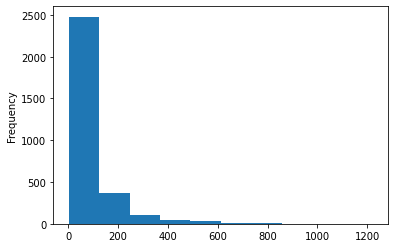

In [25]:
dfc['exp_pv_profit'].plot(kind='hist')

## 

## Profit calculations with intervention

### Function to estimate the new churn probability with an applied promotion

In [104]:
## Function to calculate the churn probability for each incentive
def inc_pred_prob(dfc, ftr, prom):
    """
    Function to calculate the churn probability for each incentive
    
    param dfc (dataframe): dataframe with all customers that are in 1st decile top churners
    param ftr (series): series with booleans related to filtering conditions for a give promotion
    param prom (string): name of the promotion applied
    
    return: NaN
    """
    
    
    ## Creating copy of the row with the modified fields
    dfx = dfc.loc[ftr, :].copy()
    
    
    ## Adjusting features based on the promotions applied
    
    ## Monthly Usage Discount
    if prom == 'Monthly Usage Discount':
        print('Monthly Usage Discount process')

        #### 
        dfx.loc[ftr, 'mou'] = dfx.loc[ftr, 'mou'].quantile(0.8) 
    
    ## New Phone
    elif prom == 'New Phone':
        print('New Phone process')
    
        #### Restarting the number of days of the current equipment
        dfx.loc[ftr, 'eqpdays'] = 0

        #### Changing to a non refurbished handset
        dfx.loc[ftr, 'refurb'] = 0

        #### Changing to web capable phone
        dfx.loc[ftr, 'webcap'] = 1
        
        #### Adjusting the price of the handset
        dfx.loc[ftr, 'setprc'] = np.maximum(dfx.loc[ftr, 'setprc'], 81.85)
        
    ## Prune Inactive Users
    elif prom == 'Prune Inactive Users':
        print('Prune Inactive Users process')
        
        #### Adjusting the price of the handset
        dfx.loc[ftr, 'setprc'] = dfx.loc[ftr, 'actvsubs']
    
    
    ## Estimating the new churn probability with the new parameters
    print("DF shape fed into model: ", dfx.loc[ftr, m1f].shape)
    pp = m1.predict(dfx.loc[ftr, m1f])
    
    ## Adding the predicted probabilities to the original dataframe
    dfc.loc[ftr, 'prom_pred_prob'] = pp
    
    
    return 

### Customer selection criteria for each promotion

In [150]:
## Promotions dictionary
proms = {
    
    
    ## Selecting out clients who might have lower churn if they get inactive users removed
    'Prune Inactive Users': {
        'selection': (dfc['uniqsubs'] - dfc['actvsubs'] > 1)
    },
    
    ## 
    'Monthly Usage Discount': { 
        'selection': (dfc['mou'] < dfc['mou'].quantile(0.1))
    },
    
    # ## Selecting out clients who might have lower churn if they get a new device
    # 'New Phone': { 
    #     'selection': ((dfc['refurb'] == 1) | (dfc['eqpdays'] >= dfc['eqpdays'].quantile(0.9)) | (dfc['webcap'] == 0))
    # },
}

In [151]:
## Creating empty column that then will be overwritten with the different promotions
dfc['prom_sel'] = 'no_promotion'
dfc['prom_pred_prob'] = np.nan

## Tagging all customer that fall under a certain promotion selection criteria
for prom in proms:
    
    print(prom)
    
    dfc.loc[proms[prom]['selection'], 'prom_sel'] = prom
    
    print(dfc.loc[proms[prom]['selection'], 'prom_sel'].shape)
    
    inc_pred_prob(dfc, proms[prom]['selection'], prom)

Prune Inactive Users
(351,)
Prune Inactive Users process
DF shape fed into model:  (351, 66)
Monthly Usage Discount
(301,)
Monthly Usage Discount process
DF shape fed into model:  (301, 66)


ValueError: shapes (301,66) and (67,) not aligned: 66 (dim 1) != 67 (dim 0)

In [95]:
dfc['prom_sel'].value_counts(normalize=True)

no_promotion            0.708594
Prune Inactive Users    0.291406
Name: prom_sel, dtype: float64

### Discount on new, web-capable equipment
- Working with variable `eqpdays`

# 

# Header

# *Notes*

### Testing weird behavior calculating predictions

In [ ]:
## Works
x = dfm1_test.loc[1099785:1099979, m1f]
m1.predict(x)

## Doesn't work
x = dfm1_test.loc[1099971:1099979, m1f]
m1.predict(x)

## Doesn't work
x = dfm1_test.loc[1099971:1099979, m1f].values
m1.predict(x)

## Doesn't work
x_matrix = sm.add_constant(dfm1_test.loc[1099971:1099979, m1f])
m1.predict(x_matrix)

### Old dict

In [ ]:
## Promotions dictionary
proms = {
    
    ## Selecting out clients who might have lower churn if they get a customer service call asking them about their service and notifying them of either/both "block calls from unknown numbers" setting and referral promotion.
    'Customer Service Call': {
        'selection': (dfc['m1_pred_prob_grade'] == 1),
    },
    
    ## Selecting out clients who might have lower churn if they get inactive users removed
    'Prune Inactive Users': {
        'selection': (dfc['m1_pred_prob_grade'] == 1) & (dfc['uniqsubs'] - dfc['actvsubs'] > 0)
    },
    
    ## Selecting out clients who might have lower churn if they get a new device
    'New Phone': { # These people are grade 1 churn risks with a refurbished, old, or non-web device
        'selection': (dfc['m1_pred_prob_grade'] == 1) & ((dfc['refurb'] == 1) | (dfc['eqpdays'] >= dfc['eqpdays'].quantile(0.75)) | (dfc['webcap'] == 0)),
    },
}

## Model 2
### Logistic regression with regularization

##### Model dataset

In [ ]:
dfm2_train = df_train.copy()
dfm2_test = df_test.copy()

##### Model label and features

In [ ]:
## Label
m2l = 'churndep'

## Features
m2f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    'revenue',
    'mou',
    'recchrge',
    'directas',
    'overage',
    'roam',
    'changem',
    'changer',
    'dropvce',
    'blckvce',
    'unansvce',
    'custcare',
    'threeway',
    'mourec',
    'outcalls',
    'incalls',
    'peakvce',
    'opeakvce',
    'dropblk',
    'callfwdv',
    'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    'phones',
    'models',
    'eqpdays',
    'age1',
    'age2',
    'children',
    'credita',
    'creditaa',
    'prizmrur',
    'prizmub',
    'prizmtwn',
    'refurb',
    'webcap',
    'truck',
    'rv',
    'occprof',
    'occcler',
    'occcrft',
    'occstud',
    'occhmkr',
    'occret',
    'occself',
    'ownrent',
    'marryun',
    'marryyes',
    'mailord',
    'mailres',
    'mailflag',
    'travel',
    'pcown',
    'creditcd',
    'retcalls',
    'retaccpt',
    'newcelly',
    'newcelln',
    'refer',
    'incmiss',
    'income',
    'mcycle',
    'setprcm',
    'setprc',
    'retcall',
    'rec_ntile',
    'freq_ntile',
    'mon_ntile',
]

##### Model training

In [ ]:
m2 = logit_reg(
    a=dfm2_train[m2l],
    b=dfm2_train[m2f],
    alpha=3,
)

##### Model coefficients

In [ ]:
m2.summary()

In [ ]:
dfm2_or = odds_ratios(m2)
dfm2_or

##### Features selection

In [ ]:
## Adding the standard deviation column to the odds ratios dataframe
dfm2_or = dfm2_or.join(
    dfi.loc[:, 'std']
)

## Operation between resulting odds ratios and standard deviation
dfm2_or['or**std'] = dfm2_or['Odds ratios']**dfm2_or['std']

## Calculating absolute difference between resulting column and 1
dfm2_or['diff_or**std'] = abs(1 - dfm2_or['or**std'])

## Ranking results
dfm2_or['rank'] = dfm2_or['diff_or**std'].rank(ascending=False)
dfm2_or.sort_values(by='rank', inplace=True, ascending=True)

##### Predictions

In [ ]:
## Churn predicted probability
dfm2_test['m2_pred_prob'] = m2.predict(dfm2_test[m2f])

## Classifying churners in groups
dfm2_test['m2_pred_prob_grade'] = 10 - ntile(dfm2_test['m2_pred_prob'], 10)

##### 

## Model 3
### Logistic regression with features selected from model 1

##### Model dataset

In [ ]:
dfm3_train = df_train.copy()
dfm3_test = df_test.copy()

##### Model label and features

In [ ]:
## Label
m3l = 'churndep'

## Features
m3f = [
    # 'calibrat',
    # 'churn',
    # 'churndep',
    # 'revenue',
    'mou',
    # 'recchrge',
    # 'directas',
    # 'overage',
    # 'roam',
    'changem',
    'changer',
    'dropvce',
    # 'blckvce',
    # 'unansvce',
    # 'custcare',
    # 'threeway',
    # 'mourec',
    # 'outcalls',
    # 'incalls',
    # 'peakvce',
    # 'opeakvce',
    # 'dropblk',
    # 'callfwdv',
    # 'callwait',
    'months',
    'uniqsubs',
    'actvsubs',
    # 'phones',
    # 'models',
    'eqpdays',
    # 'age1',
    # 'age2',
    # 'children',
    # 'credita',
    'creditaa',
    # 'prizmrur',
    # 'prizmub',
    # 'prizmtwn',
    # 'refurb',
    # 'webcap',
    # 'truck',
    # 'rv',
    # 'occprof',
    # 'occcler',
    # 'occcrft',
    # 'occstud',
    # 'occhmkr',
    # 'occret',
    # 'occself',
    # 'ownrent',
    # 'marryun',
    # 'marryyes',
    # 'mailord',
    # 'mailres',
    # 'mailflag',
    # 'travel',
    # 'pcown',
    # 'creditcd',
    # 'retcalls',
    # 'retaccpt',
    # 'newcelly',
    # 'newcelln',
    # 'refer',
    # 'incmiss',
    # 'income',
    # 'mcycle',
    # 'setprcm',
    # 'setprc',
    'retcall',
    # 'rec_ntile',
    # 'freq_ntile',
    # 'mon_ntile',
]

##### Model training

In [ ]:
m3 = logit_reg(
    a=dfm3_train[m3l],
    b=dfm3_train[m3f],
    alpha=0,
)

##### Model coefficients

In [ ]:
m3.summary()

In [ ]:
odds_ratios(m3)

##### Model predictions

In [ ]:
## Churn predicted probability
dfm3_test['m3_pred_prob'] = m3.predict(dfm3_test[m3f])

## Classifying churners in groups
dfm3_test['m3_pred_prob_grade'] = 10 - ntile(dfm3_test['m3_pred_prob'], 10)

## 

---

---